# Import Libs

In [1]:
import os
import cv2
import shutil
import datetime
import numpy as np
import seaborn as sns
import tensorflow as tf 
import albumentations as A
import matplotlib.pylab as plt 
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1,L2
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import confusion_matrix, roc_curve,f1_score
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau, TensorBoard
from tensorflow.keras.metrics import BinaryAccuracy,binary_accuracy, TruePositives, FalsePositives, FalseNegatives, TrueNegatives,Precision,Recall, AUC
from tensorflow.keras.layers import (Dense, Conv2D, MaxPooling2D, Flatten, InputLayer, BatchNormalization, Input, Layer,Dropout,
                                     RandomFlip, RandomRotation, Resizing, Rescaling #for augmentation
                                     )

In [2]:
tf.__version__

'2.10.0'

# Load Malaria Dataset

In [3]:
dataset, dataset_info = tfds.load('malaria',with_info=True, as_supervised=True, shuffle_files = True, split = 'train')

In [4]:
tfds.__version__

'4.9.2'

# Data Split

In [5]:
TRANI_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [6]:
def splits(dataset, TRANI_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRANI_RATIO*DATASET_SIZE))
    val_test__dataset = dataset.skip(int(TRANI_RATIO*DATASET_SIZE))
    val_dataset = val_test__dataset.take(int(VAL_RATIO*DATASET_SIZE))
    test_dataset = val_test__dataset.skip(int(VAL_RATIO*DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset


In [7]:
#dataset = tf.data.Dataset.range(20)
train_dataset, val_dataset, test_dataset = splits(dataset, TRANI_RATIO, VAL_RATIO, TEST_RATIO)

# Data Visualizing

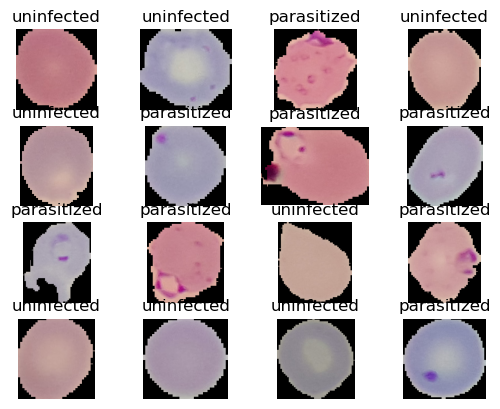

In [8]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

In [9]:
 dataset_info.features['label'].int2str(0)

'parasitized'

# Augmentation

In [10]:
IM_SIZE = 224

## Albumentations

In [11]:
transforms = A.Compose([
            A.Resize(IM_SIZE, IM_SIZE),
            A.OneOf([A.HorizontalFlip(),
                     A.VerticalFlip()]),
            A.RandomRotate90(),
            #A.RandomGridShuffle(grid=(3,3), always_apply=False, p = 0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, always_apply=False, p = 0.5),
            A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0),  always_apply=False, p = 0.5)

        ])

In [12]:
def aug_albument(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    return aug_img

In [13]:
def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
    return aug_img, label

# Data Preprocessing

In [14]:
BATCH_SIZE = 32
train_dataset = (train_dataset
                 .shuffle(buffer_size= 8 , reshuffle_each_iteration= True)
                 .map(process_data) # augmentation with Albumentation
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE))
val_dataset = (val_dataset
               .shuffle(buffer_size= 8 , reshuffle_each_iteration= True)
                .map(process_data) # augmentation with Albumentation
               .batch(BATCH_SIZE)
               .prefetch(tf.data.AUTOTUNE))

#test_dataset = test_dataset.map(resizing_rescaling_layers)

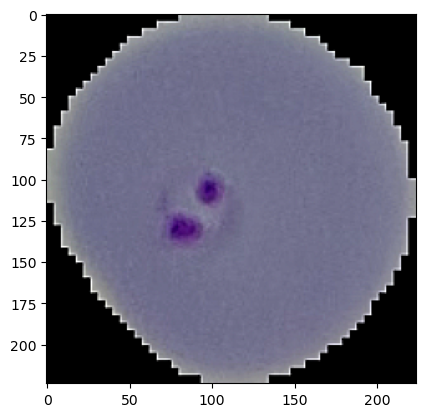

In [15]:
im, lbl = next(iter(train_dataset))
plt.imshow(im[0])

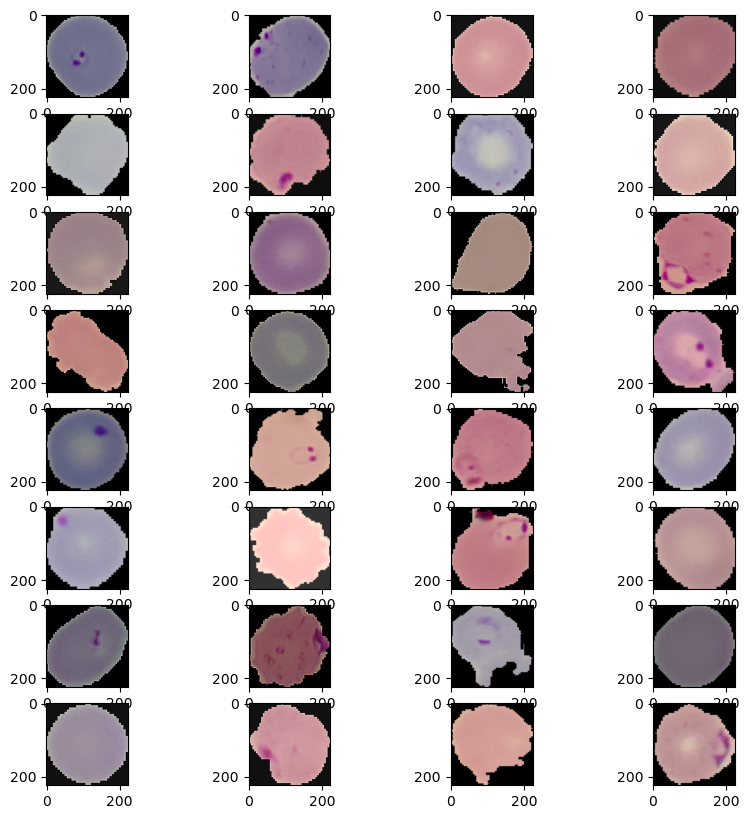

In [16]:
plt.figure(figsize=(10, 10))
for i in range(32):
    plt.subplot(8, 4, i+1)
    plt.imshow(im[i])

# Callbacks

## Tensorbourd

In [17]:
LOG_DIR_FOR_DELETE = './logs'

# Check if the folder exists
if os.path.exists(LOG_DIR_FOR_DELETE) and os.path.isdir(LOG_DIR_FOR_DELETE):
    # Delete the folder
    shutil.rmtree(LOG_DIR_FOR_DELETE)
    print("The folder has been deleted successfully!")
else:
    print("The folder does not exist")

The folder has been deleted successfully!


In [18]:
CURRENT_TIME = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
CUSTOM_TRAIN_DIR = './logs/' + CURRENT_TIME + '/custom/train'
CUSTOM_VAL_DIR = './logs/' + CURRENT_TIME + '/custom/val'
custom_train_writer = tf.summary.create_file_writer(CUSTOM_TRAIN_DIR)
custom_val_writer = tf.summary.create_file_writer(CUSTOM_VAL_DIR)

# BuildModel

In [19]:
sequential_model = tf.keras.Sequential([
    InputLayer(input_shape= (IM_SIZE, IM_SIZE,3)),

    Conv2D(filters= 8,kernel_size=3, strides=1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2),

    Conv2D(filters= 16,kernel_size=3, strides=1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),

    Dense(units=100, activation='relu'),
    BatchNormalization(),

    Dense(units=10, activation='relu'),
    BatchNormalization(),

    Dense(units=1, activation='sigmoid')
])
sequential_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                        

# Custom Metric

## Custom Metric Method (Without parameters)

In [20]:
def custom_accuracy(y_true, y_pred):
    return binary_accuracy(y_true, y_pred)

## Custom Metric Method (With parameters)

In [21]:
def custom_accuracy(FACTOR = 1):
    def metric(y_true, y_pred):
        return binary_accuracy(y_true, y_pred)*FACTOR
    return metric

## Custom Metric Class

In [22]:
class CustomAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name = 'Custom_Accuracy', FACTOR = 1):
        super(CustomAccuracy, self).__init__()
        self.FACTOR = FACTOR
        self.accuracy = self.add_weight(name = name, initializer = 'zeros')
    def update_state(self, y_true, y_pred, sample_weight = None):
        output = binary_accuracy(tf.cast(y_true, dtype = tf.float32), y_pred)*self.FACTOR
        self.accuracy.assign(tf.math.count_nonzero(output, dtype = tf.float32)/tf.cast(len(output), dtype = tf.float32))
    def result(self):
        return self.accuracy
    def reset_state(self):
        self.accuracy.assign(0.)

# Custom Loss

## Custom Loss Method (Without parameters)

In [23]:
def custom_bce1(y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred)

## Custom Loss Method (With parameters)

In [24]:
def custom_bce2(FACTOR = 1):
    def loss(y_true, y_pred):
        bce = BinaryCrossentropy()
        return bce(y_true, y_pred)*FACTOR
    return loss

# Custom Loss Class

In [25]:
class CustomBCE(tf.keras.losses.Loss):
    def __init__(self, FACTOR):
        super(CustomBCE, self).__init__()
        self.FACTOR = FACTOR
    def call(self, y_true, y_pred):
        bce = BinaryCrossentropy()
        return bce(y_true, y_pred)*self.FACTOR

# Custom Training Loop

In [26]:
@tf.function
def training_block(model, loss_function,METRIC, OPTIMIZER, x_batch, y_batch):
  with tf.GradientTape() as recorder:
    y_pred = model(x_batch, training = True)
    loss = loss_function(y_batch, y_pred)

  partial_derivatives = recorder.gradient(loss, sequential_model.trainable_weights)
  OPTIMIZER.apply_gradients(zip(partial_derivatives, sequential_model.trainable_weights))
  METRIC.update_state(y_batch, y_pred)
  return loss

In [27]:
@tf.function
def val_block(model, loss_function,VAL_METRIC, OPTIMIZER, x_batch_val, y_batch_val):
    y_pred_val = model(x_batch_val, training = False)
    loss_val = loss_function(y_batch_val, y_pred_val)
    VAL_METRIC.update_state(y_batch_val, y_pred_val)
    return loss_val

In [28]:
def neurallearn(model, loss_function, METRIC, VAL_METRIC, OPTIMIZER, train_dataset, val_dataset, EPOCHS):
  for epoch in range(EPOCHS):
    print("Epoch number is {}".format(epoch))
    for step , (x_batch, y_batch) in enumerate(train_dataset):
      loss = training_block(model, loss_function,METRIC, OPTIMIZER, x_batch, y_batch)
    print("The loss is {}".format(loss))
    print("The Accuracy is {}".format(METRIC.result()))
    with custom_train_writer.as_default():
        tf.summary.scalar('Training Loss', data = loss, step = epoch)
    with custom_train_writer.as_default():
        tf.summary.scalar('Training Accuracy', data = METRIC.result(), step = epoch)
    METRIC.reset_states()

    for (x_batch_val, y_batch_val) in val_dataset:
      val_loss = val_block(model, loss_function,VAL_METRIC, OPTIMIZER, x_batch_val, y_batch_val)
    print("The validation loss is {}".format(val_loss))
    print("The Accuracy is {}".format(VAL_METRIC.result()))
      
    with custom_val_writer.as_default():
        tf.summary.scalar('Validation Loss', data = val_loss, step = epoch)
    with custom_val_writer.as_default():
        tf.summary.scalar('Validation Accuracy', data = VAL_METRIC.result(), step = epoch)
        
    VAL_METRIC.reset_states()
  print("The training finished!")



In [29]:
OPTIMIZER = Adam(learning_rate = 0.1)
METRIC = CustomAccuracy()
VAL_METRIC = CustomAccuracy()
EPOCHS = 2

In [30]:
neurallearn(sequential_model, custom_bce1, METRIC, VAL_METRIC, OPTIMIZER, train_dataset, val_dataset, EPOCHS)

Epoch number is 0
The loss is 0.3530469238758087
The Accuracy is 1.0
The validation loss is 0.11329833418130875
The Accuracy is 1.0
Epoch number is 1
The loss is 0.3285664916038513
The Accuracy is 1.0
The validation loss is 1.489463448524475
The Accuracy is 1.0
The training finished!


# Visualizations

## tensorboard

In [31]:
%load_ext tensorboard

In [32]:
tensorboard --logdir='./logs' --host=127.0.0.1 --port=6012